In [3]:
print("The start of Optimisation HW1!")
print("These are not the droids you're looking for")

The start of Optimisation HW1!
These are not the droids you're looking for


In [4]:
#Import relevant libraries
import sklearn
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import scipy.linalg
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time

In [5]:
random.seed(69)
np.random.seed(69)

In [ ]:
def createDataset():
    #Let's start to generate the points using two functions: sine and cosine
    range = (-5*np.pi, 5*np.pi)
    n = 5000 #number of points
    perm = np.random.permutation(n//2)
    x_0 = np.random.uniform(*range, n//2)
    f_sin = np.sin(0.6*x_0) #function for class -1
    f_cos = np.cos(0.6*x_0+np.pi/2) #fuction for class 1

    #Visualize the graphs without noise
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Graphs of sin and cos without noise")
    plt.scatter(x_0, f_sin, alpha=0.6, s=30, color="m")
    plt.scatter(x_0, f_cos, alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-15, 15)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    #Let's add some noise 
    noise = np.random.normal(0, 0.1, len(x_0))
    new_fsin = f_sin + noise
    new_fcos = f_cos + noise 

    #Graphs visualization with noise 
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Graphs of sin and cos with noise")
    plt.scatter(x_0, new_fsin, alpha=0.6, s=30, color="m")
    plt.scatter(x_0, new_fcos, alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-15, 15)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    class_0 = np.array(list(zip(x_0, new_fsin)))
    class_1 = np.array(list(zip(x_0, new_fcos)))

    return class_0, class_1

def split_data(class0, class1, labeled_pct, initialize_random=True):
    scaler = StandardScaler().fit(np.concatenate((class0, class1)))
    split_0 = int(len(class0) * labeled_pct) #number of data with labels according to percentage provided for class 0
    split_1 = int(len(class1) * labeled_pct) #same for class 1

    x_bar_0 = scaler.transform(class0[:split_0]) #transforms on the range of the labeled data 
    x_bar_1 = scaler.transform(class1[:split_1])
    x_0 = scaler.transform(class0[split_0:]) #transforms on the range of the unlabeled data 
    x_1 = scaler.transform(class1[split_1:])

    #Creating the labels and variables for label and unlabel data 
    y_bar_0 = np.full(len(x_bar_0), -1) #assigns -1 to a vector of size x_bar_0, creating labeled data for class -1
    y_bar_1 = np.full(len(x_bar_1), 1)  #assigns 1 to a vector of size x_bar_1, creating labeled data for class 1 
    y_0 = np.full(len(x_0), -1) #creating the target vector for class -1
    y_1 = np.full(len(x_1), 1) #creating the target vector for class 1 

    #Concatenates variables of both classes to create label 
    x_labeled = np.concatenate((x_bar_0, x_bar_1)) #list of coordinates (x, y) of labeled data 
    y_labeled = np.concatenate((y_bar_0, y_bar_1)) #list of classes 
    
    """# Shuffle labeled set
    perm_labeled = np.random.permutation(len(x_labeled))
    x_labeled = x_labeled[perm_labeled]
    y_labeled = y_labeled[perm_labeled]
    """
    #Concatenates variables of both classes to create unlabel variables 
    x_unlabeled = np.concatenate((x_0, x_1)) #list of coordiantes (x, y) of unlabeled data
    y_unlabeled_target = np.concatenate((y_0, y_1)) #list of target classes

    """
    # Shuffle unlabeled set
    perm_unlabeled = np.random.permutation(len(x_unlabeled))
    x_unlabeled = x_unlabeled[perm_unlabeled]
    y_unlabeled_target = y_unlabeled_target[perm_unlabeled]
    """

    #2 ways to initialize the labels to predict 
    if initialize_random:
        y_unlabeled_initial = np.random.choice([-1, 1], len(x_unlabeled))
    else:
        y_unlabeled_initial = np.zeros(len(x_unlabeled))

    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial

def plottingData(x_labeled, y_labeled, x_unlabeled, y_unlabeled_target):
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Unlabeled points true value")
    plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Labeled points true value")
    plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Labeled and unlabeled points")
    plt.scatter([p[0] for p in x_unlabeled], [p[1] for p in x_unlabeled], c="grey")
    plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Unlabeled", "Labeled -1", "Labeled 1"])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    return 

def prepareArtifitialData():
    class0, class1 = createDataset()
    x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial = split_data(class0, class1, 0.1)
    plottingData(x_labeled, y_labeled, x_unlabeled, y_unlabeled_target)
    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial

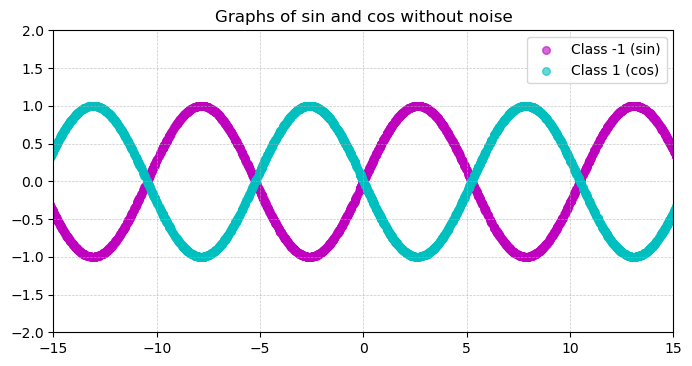

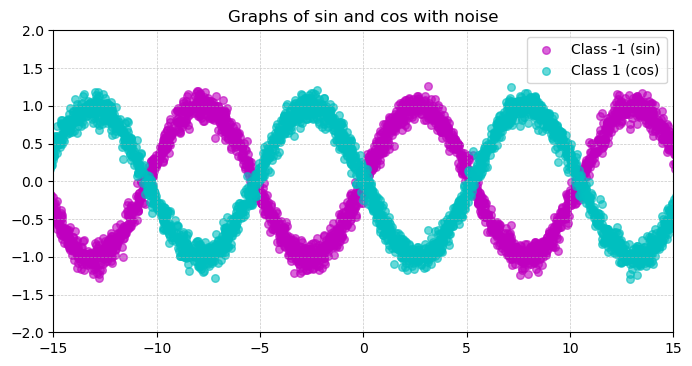

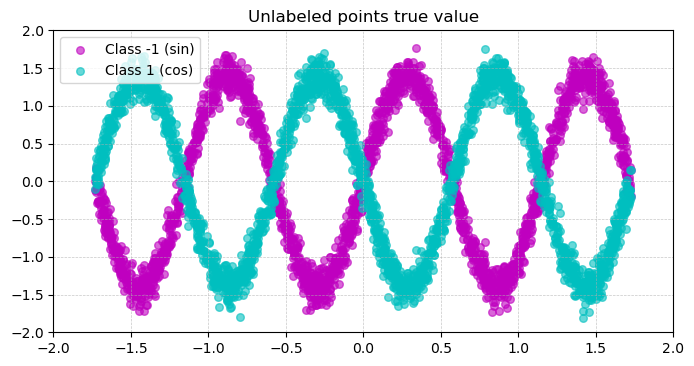

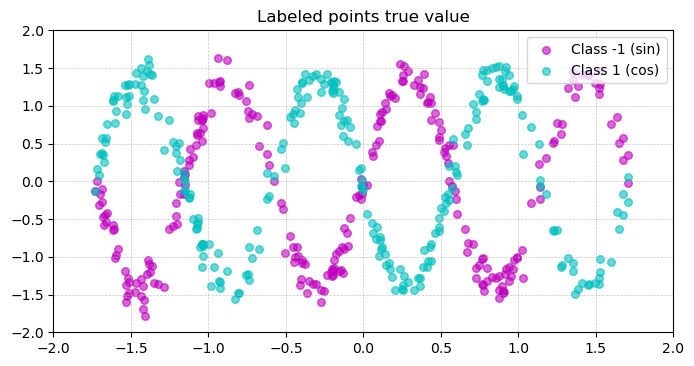

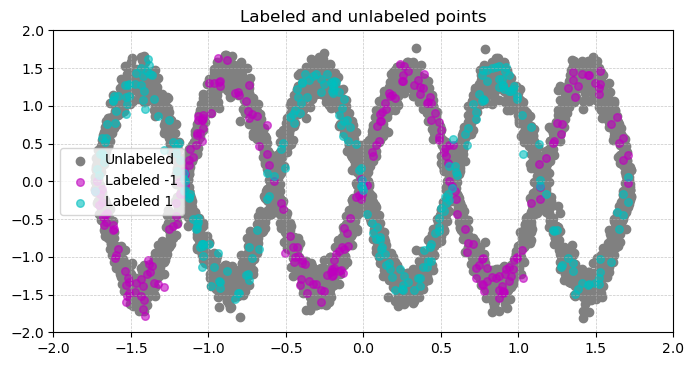

In [7]:
x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial = prepareArtifitialData()

In [8]:
# Define weight arrays using Gaussian (RBF) Kernel as similarity measure 

#Array w_ij is the weights array between labeled examples and unlabeled examples
dist_labeled_unlabeled = cdist(x_labeled, x_unlabeled, metric='euclidean')
w_ij = np.exp(-0.5 * dist_labeled_unlabeled ** 2)

#Array w_ij_bar is the weights array between unlabeled examples and unlabeled examples
dist_unlabeled_unlabeled = cdist(x_unlabeled, x_unlabeled, metric='euclidean')
w_ij_bar = np.exp(-0.5 * dist_unlabeled_unlabeled ** 2)

print(w_ij.shape, w_ij_bar.shape)

(500, 4500) (4500, 4500)


In [9]:
w_ij_bar[0:5]

array([[1.        , 0.89792967, 0.30394507, ..., 0.76855997, 0.23350289,
        0.25371182],
       [0.89792967, 1.        , 0.16403575, ..., 0.92017255, 0.14584044,
        0.34613479],
       [0.30394507, 0.16403575, 1.        , ..., 0.07859279, 0.86754616,
        0.12959994],
       [0.38431483, 0.41872413, 0.30937977, ..., 0.23267468, 0.4779059 ,
        0.88698041],
       [0.12583284, 0.22871892, 0.03142139, ..., 0.14889679, 0.06976806,
        0.82552305]])

In [10]:
#Implement BCGD

#First, define the loss function

def loss(given_labels, predicted_labels):
    
   #Representing points as vectors for ease of calculations
    y = np.copy(predicted_labels).astype("float64").reshape((-1,1))
    y_bar = np.copy(given_labels).astype("float64").reshape((-1,1))

    diff_t1 = y-y_bar.T
    diff_t1_sq = np.power(diff_t1,2)
    loss_matrix_t1 = diff_t1_sq*w_ij.T
    total_loss_t1 = np.sum(loss_matrix_t1)

    diff_t2 = y-y.T
    diff_t2_sq = np.power(diff_t2,2)
    loss_matrix_t2 = diff_t2_sq*w_ij_bar.T
    total_loss_t2 = np.sum(loss_matrix_t2)

    return total_loss_t1 + total_loss_t2


In [ ]:
#Define accuracy measures
# accuracy score, rounding current to {-1,1} and comparing with target
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)

# accuracy from a loss point of view, however it has the problem that
# the minimum of the loss might be greater than 0
max_loss = np.sum(w_ij) * 4 + np.sum(w_ij_bar) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

# accuracy from a target point of view, aka distance from current to target
initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=1)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=1)
    return 1 - current_distance / initial_distance

# the accuracy used as proxy to switch from one to another
def accuracy(current):
    return accuracy_norm(current)

def accuracy2(current_prediction):
    return accuracy_score(y_unlabeled_target, current_prediction)


In [12]:
#Define Hessian Matrix to estimate Lipschitz constant

USE_LIPSCHITZ_CONSTANT = True
OUTPUT_STEP = 0.1
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
STEP_SIZE = 1e-2

def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]) - w_unlabeled_unlabeled[i][i]
    print()
    return mat * 2

def estimate_lipschitz_constant(hessian):
    # max eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

def estimate_degree_strongly_convex(hessian):
    # min eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(w_ij_bar, w_ij)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 308.43631526162017,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 4303.3306294485765
Estimating Lipschitz constant for each single variable
Done


In [13]:
#Calculating constants that will be used in the Gradient Descent Method

print("Calculating coefficients of the gradient")
row_sum_w = np.sum(w_ij, axis=0).reshape((-1,1))
row_sum_w_ = np.sum(w_ij_bar, axis=0).reshape((-1,1))
Cij = (row_sum_w + row_sum_w_)
b = np.multiply(
    y_labeled.reshape((-1,1)),
    w_ij
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


In [14]:
#Defining the gradient function

def gradient(y):
    unlabeled = y.reshape((-1,1))
    third_coeff = np.dot(w_ij_bar.T, unlabeled)
    return 2 * (Cij * unlabeled - b - third_coeff).reshape((-1,))

In [15]:
#Defining functions for the gradient calculation for block selection

def derivative(y, j):
    return 2 * (Cij[j] * y[j] -
           b[j] -
           np.matmul(w_ij_bar[:,j], y.T))

def update_gradient(previous_grad, Li, index):
    global w_ij_bar, Cij
    step = 1/Li * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += 2* w_ij_bar[index] * step
    new_grad[index] -= 2 * Cij[index] * step
    return step, new_grad

In [16]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [17]:
print(y_unlabeled_gd[0:10])

[ 1 -1  1 -1  1 -1 -1  1 -1  1]


In [ ]:
#Implementation of GD
def GD(NUM_ITERS, y_unlabeled):

    ticks_gd = [0]
    accuracies_gd = [accuracy2(y_unlabeled)]
    losses_gd = [loss(y_labeled, y_unlabeled)]
    init_time = time.time() * 1000
    for i in range(NUM_ITERS):
        if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
            print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

        start = time.process_time()
        grad = gradient(y_unlabeled)

        if EPSILON >= np.linalg.norm(grad):
            break

        y_unlabeled = y_unlabeled - 1/L * grad
        y_unlabeled_gd_hard= np.where(y_unlabeled > 0, 1, -1)  # Converts to 1 or -1, from soft to hard predictions
        accuracies_gd.append(accuracy2(y_unlabeled_gd_hard))
        losses_gd.append(loss(y_labeled, y_unlabeled))
        ticks_gd.append(time.time() * 1000 - init_time)

        if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
            print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {losses_gd[-1]:05.2f}")

    print(f"""
    Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
    Norm gradient: {np.linalg.norm(gradient(y_unlabeled))}
    Loss: {loss(y_labeled, y_unlabeled)}
    """)
    return y_unlabeled, ticks_gd, accuracies_gd

In [272]:
y_unlabeled_gd, ticks_gd, accuracies_gd= GD(50, y_unlabeled_gd)

00% - iter 0 / 50 - final accuracy 49.20% - loss 1780007.66
10% - iter 5 / 50 - final accuracy 56.09% - loss 695770.18
20% - iter 10 / 50 - final accuracy 58.16% - loss 695236.94
30% - iter 15 / 50 - final accuracy 57.64% - loss 695234.13
40% - iter 20 / 50 - final accuracy 57.24% - loss 695231.40


KeyboardInterrupt: 

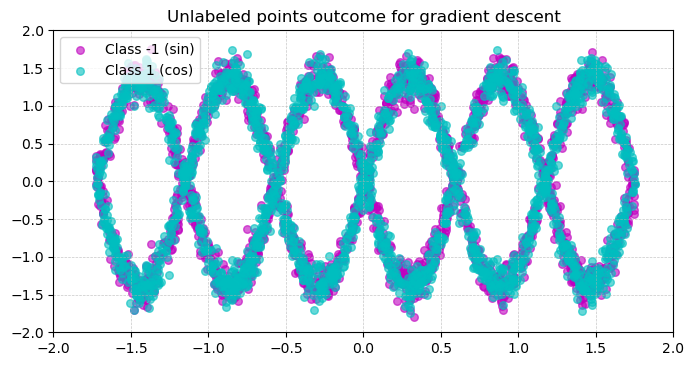

In [273]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Unlabeled points outcome for gradient descent")
final_y_unlabeled = (y_unlabeled_gd/2 + .5).round() * 2 - 1
plt.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]], alpha=0.6, s=30, color="m")     
plt.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]], alpha=0.6, s=30, color="c")
plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

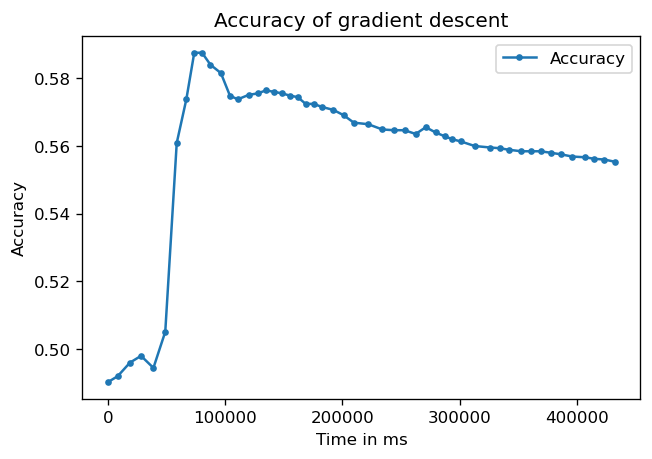

In [250]:
plt.figure(dpi=120)
plt.title("Accuracy of gradient descent")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.legend(["Accuracy"])


In [19]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [ ]:
#Implement the BCGD with GS
def BCGD(NUM_ITERS, y_unlabeled_bcgd, EPSILON = 1e-11):

    ticks_bcgd_gs = [0]
    accuracies_bcgd_gs = [accuracy2(y_unlabeled_bcgd)]
    losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd)]

    max_iterations = NUM_ITERS*len(y_unlabeled_bcgd)
    previous_grad_gs = gradient(y_unlabeled_bcgd)

    init_time = time.time() * 1000

    for i in range(max_iterations):
        if i % (max_iterations * OUTPUT_STEP) == 0 :
            print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

        index = np.argmax(np.abs(previous_grad_gs))

        step, new_grad = update_gradient(previous_grad_gs, Li[index], index)
        y_unlabeled_bcgd[index] = y_unlabeled_bcgd[index] - step
        previous_grad_gs = new_grad

        if EPSILON >= np.linalg.norm(previous_grad_gs):
            break

        if (i+1) % len(y_unlabeled_target) == 0:
            y_unlabeled_bcgd_hard= np.where(y_unlabeled_bcgd > 0, 1, -1)
            accuracies_bcgd_gs.append(accuracy2(y_unlabeled_bcgd_hard))
            losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd))
            ticks_bcgd_gs.append(time.time() * 1000 - init_time)

        if i % (max_iterations * OUTPUT_STEP) == 0 :
            print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd):05.2f}")


    print(f"""
    Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
    Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd))}
    Loss: {loss(y_labeled, y_unlabeled_bcgd)}
    """)
    return y_unlabeled_bcgd, ticks_bcgd_gs, accuracies_bcgd_gs

In [ ]:
y_unlabeled_bcgd_gs, ticks_bcgd_gs, accuracies_bcgd_gs = BCGD(50, y_unlabeled_bcgd_gs)

00% - iter 0 / 225000 - final accuracy 49.02% - loss 13907829.94
10% - iter 22500 / 225000 - final accuracy 50.51% - loss 696053.58


KeyboardInterrupt: 

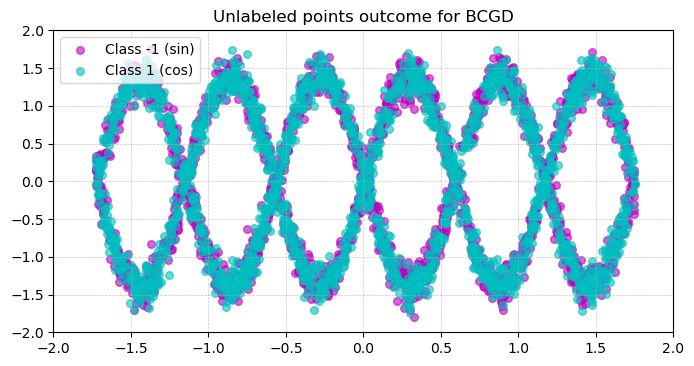

In [277]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Unlabeled points outcome for BCGD")
final_y_unlabeled_ = (y_unlabeled_bcgd_gs/2 + .5).round() * 2 - 1
plt.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]], alpha=0.6, s=30, color="m")     
plt.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]], alpha=0.6, s=30, color="c")
plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

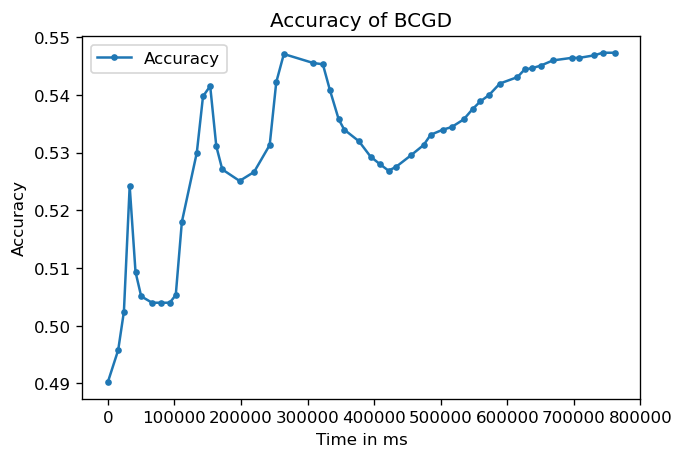

In [254]:
plt.figure(dpi=120)
plt.title("Accuracy of BCGD")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.legend(["Accuracy"])

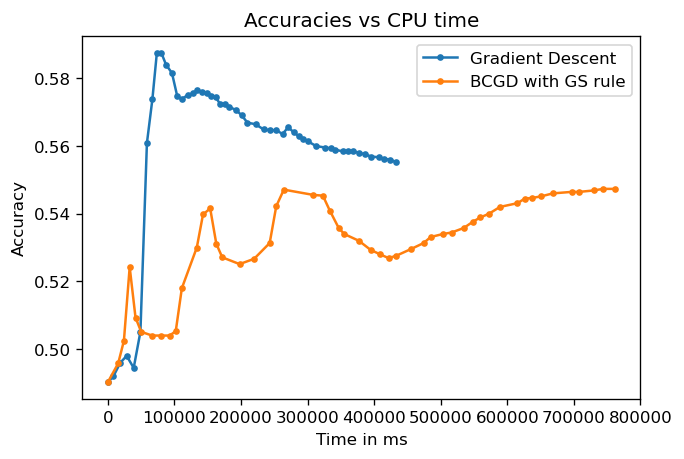

In [255]:
plt.figure(dpi=120)
plt.title("Accuracies vs CPU time")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.legend(["Gradient Descent", "BCGD with GS rule"])

In [21]:
def getpublicData():
    #Necessary to use the public dataset
    !pip3 install -U ucimlrepo

    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

    # data (as pandas dataframes)
    X = breast_cancer_wisconsin_diagnostic.data.features #we save the features of our data 
    y = breast_cancer_wisconsin_diagnostic.data.targets #and the labels 

    # metadata
    print(breast_cancer_wisconsin_diagnostic.metadata)

    # variable information
    print(breast_cancer_wisconsin_diagnostic.variables)
    return X, y

def preparePublicData(X, y_labels):
    x_pb = X[:]["radius1"] #radius1 will be coordinate x
    y_pb = X[:]["texture1"] #texture1 will be coordinate y 

    mask_B = y_labels["Diagnosis"]=="B" #filters the data labeled with B
    indices_B = list(y_labels[mask_B].index) #obtains the indices for B
    indices_M = list(y_labels[-mask_B].index) #obtains the indices for M 

    x_B = x_pb[indices_B] #coordinates x of benign 
    x_M = x_pb[indices_M] #coordinates x of malignant

    y_B = y_pb[indices_B] #coordinates y of benign
    y_M = y_pb[indices_M] #coordinates y of malignant

    points_B = np.array(list(zip(x_B, y_B))) #gets points labeled with B
    points_M = np.array(list(zip(x_M, y_M))) #gets points labeled with M

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Breast Cancer Dataset")
    plt.scatter(x_B, y_B, alpha=0.6, s=30, color="c")
    plt.scatter(x_M, y_M, alpha=0.6, s=30, color="m")
    plt.legend(["Benign", "Malignant"])
    plt.xlabel("Radius")
    plt.ylabel("Texture")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    return points_B, points_M



{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

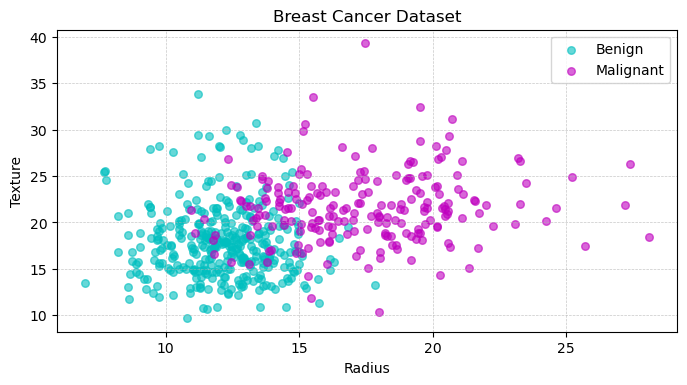

In [28]:
X, y_labels = getpublicData()
points_B, points_M = preparePublicData(X, y_labels)
x_labeled_pd, y_labeled_pd, x_unlabeled_pd, y_unlabeled_target_pd, y_unlabeled_initial_pd = split_data(points_B, points_M, 0.1)
#-1 would go for B and 1 for

In [29]:
def accuracy3(current_prediction):
    return accuracy_score(y_unlabeled_target_pd, current_prediction)

In [32]:
#Implementation of GD
def GD2(NUM_ITERS, y_unlabeled):

    ticks_gd = [0]
    accuracies_gd = [accuracy3(y_unlabeled)]
    losses_gd = [loss(y_labeled_pd, y_unlabeled)]
    init_time = time.time() * 1000
    for i in range(NUM_ITERS):
        if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
            print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

        start = time.process_time()
        grad = gradient(y_unlabeled)

        if EPSILON >= np.linalg.norm(grad):
            break

        y_unlabeled = y_unlabeled - 1/L * grad
        y_unlabeled_gd_hard= np.where(y_unlabeled > 0, 1, -1)  # Converts to 1 or -1, from soft to hard predictions
        accuracies_gd.append(accuracy3(y_unlabeled_gd_hard))
        losses_gd.append(loss(y_labeled_pd, y_unlabeled))
        ticks_gd.append(time.time() * 1000 - init_time)

        if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
            print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {losses_gd[-1]:05.2f}")

    print(f"""
    Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
    Norm gradient: {np.linalg.norm(gradient(y_unlabeled))}
    Loss: {loss(y_labeled_pd, y_unlabeled)}
    """)
    return y_unlabeled, ticks_gd, accuracies_gd

In [33]:
y_unlabeled_gd_pd = np.copy(y_unlabeled_initial_pd)
y_unlabeled_gd_pd, ticks_gd_pd, accuracies_gd_pd= GD2(50, y_unlabeled_gd_pd)

ValueError: operands could not be broadcast together with shapes (513,56) (4500,500) 

In [ ]:
#Implement the BCGD with GS
def BCGD2(NUM_ITERS, y_unlabeled_bcgd, EPSILON = 1e-11):

    ticks_bcgd_gs = [0]
    accuracies_bcgd_gs = [accuracy3(y_unlabeled_bcgd)]
    losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd)]

    max_iterations = NUM_ITERS*len(y_unlabeled_bcgd)
    previous_grad_gs = gradient(y_unlabeled_bcgd)

    init_time = time.time() * 1000

    for i in range(max_iterations):
        if i % (max_iterations * OUTPUT_STEP) == 0 :
            print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

        index = np.argmax(np.abs(previous_grad_gs))

        step, new_grad = update_gradient(previous_grad_gs, Li[index], index)
        y_unlabeled_bcgd[index] = y_unlabeled_bcgd[index] - step
        previous_grad_gs = new_grad

        if EPSILON >= np.linalg.norm(previous_grad_gs):
            break

        if (i+1) % len(y_unlabeled_target) == 0:
            y_unlabeled_bcgd_hard= np.where(y_unlabeled_bcgd > 0, 1, -1)
            accuracies_bcgd_gs.append(accuracy3(y_unlabeled_bcgd_hard))
            losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd))
            ticks_bcgd_gs.append(time.time() * 1000 - init_time)

        if i % (max_iterations * OUTPUT_STEP) == 0 :
            print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd):05.2f}")


    print(f"""
    Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
    Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd))}
    Loss: {loss(y_labeled, y_unlabeled_bcgd)}
    """)
    return y_unlabeled_bcgd, ticks_bcgd_gs, accuracies_bcgd_gs

In [ ]:
y_unlabeled_bcgd_gs_pd = np.copy(y_unlabeled_initial_pb).astype("float64")
y_unlabeled_bcgd_gs_pd, ticks_bcgd_gs, accuracies_bcgd_gs = BCGD2(50, y_unlabeled_bcgd_gs_pd)